<a href="https://colab.research.google.com/github/reemkhattarr/AML_Semantic_Segmentation/blob/main/DeepLabV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installa le librerie mancanti
!pip install -q albumentations thop gdown


In [ ]:
!pip install torch torchvision

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
print(os.listdir('/content//drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src/'))


['dataset.py', '__pycache__', 'train.py', 'eval.py', 'visualization.py', 'utils']


In [10]:
import sys

sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src')

from dataset import LoveDADataset
import matplotlib.pyplot as plt
import numpy as np

TESTING DATASET LOADING

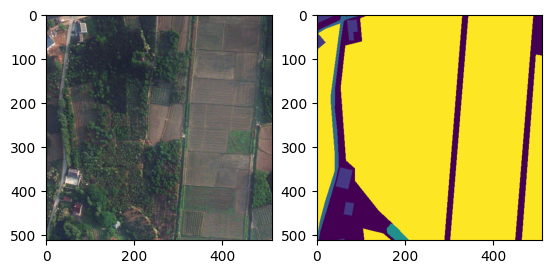

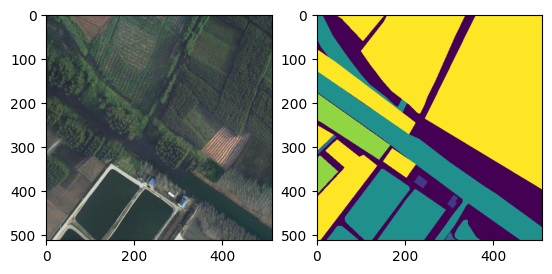

Image min/max: 0.08235294 1.0
Mask unique values: [1 2 3 4 6 7]


In [4]:
dataset = LoveDADataset(
    root='/content/drive/MyDrive/AML_Segmentation_Project/data/LoveDA',
    split='Train/Rural',
    image_dir='images_png',
    mask_dir='masks_png'
)
img, mask = dataset[0]
import matplotlib.pyplot as plt
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(mask)
plt.show()

img, mask = dataset[1]
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(mask)
plt.show()

print("Image min/max:", img.min(), img.max())
print("Mask unique values:", np.unique(mask))

TESTING MODEL

In [21]:
import torch

sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models')
print(sys.path)
from deeplabv2 import DeepLabV2


def test_deeplabv2():
    # Settings
    num_classes = 7
    batch_size = 2
    h, w = 512, 512

    # Instantiate model
    model = DeepLabV2(num_classes=num_classes, pretrained_backbone=False)
    model.eval()  # Set to eval mode

    # Create dummy input
    x = torch.randn(batch_size, 3, h, w)

    # Forward pass
    with torch.no_grad():
        y = model(x)

    # Check output shape
    assert y.shape == (batch_size, num_classes, h, w), \
        f"Output shape {y.shape} is not as expected {(batch_size, num_classes, h, w)}"
    print(f"Output shape OK: {y.shape}")

    # Check output type
    assert isinstance(y, torch.Tensor), "Output is not a torch.Tensor"
    print("Output type OK: torch.Tensor")

    # Print number of parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {n_params/1e6:.2f}M")

test_deeplabv2()

['/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src/utils', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models/', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models/', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models/', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models/', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models']


ModuleNotFoundError: No module named 'deeplabv2'

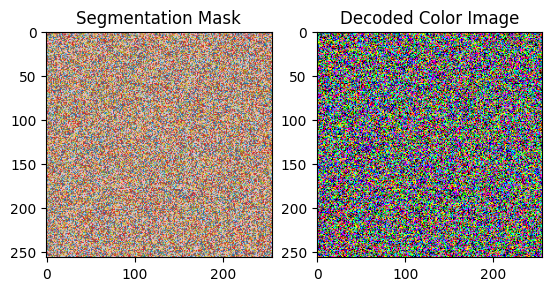

In [11]:
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src/utils/')
from visualization import decode_segmap

def test_decode_segmap():
    # Simulate a segmentation mask with 7 classes (as in LoveDA)
    mask = np.random.randint(0, 7, (256, 256), dtype=np.uint8)
    color_img = decode_segmap(mask)
    assert color_img.shape == (256, 256, 3)
    assert color_img.dtype == np.uint8

    # Visualize the result
    plt.subplot(1, 2, 1)
    plt.title("Segmentation Mask")
    plt.imshow(mask, cmap='tab20')
    plt.subplot(1, 2, 2)
    plt.title("Decoded Color Image")
    plt.imshow(color_img)
    plt.show()

test_decode_segmap()

### RUN

Imports and Setup

In [4]:
!pip install torch torchvision

In [5]:
import torchvision
print(torchvision.__version__)

ModuleNotFoundError: No module named 'torchvision'

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.clear()
sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src/utils')
sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src')
sys.path.append('/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models')
print(sys.path)

from deeplabv2 import get_deeplabv2_model
from dataset import LoveDADataset
from metrics import MeanIoU

['/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src/utils', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/src', '/content/drive/MyDrive/AML_Segmentation_Project/DeepLabV2/models']


ModuleNotFoundError: No module named 'torchvision'

Device Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Configuration

In [ ]:
# Paths
LOVEDA_ROOT = '/xontent/drive/MyDrive/AML_Segmentation_Project/data/LoveDA'
CHECKPOINT_DIR = '/xontent/drive/MyDrive/AML_Segmentation_Project/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

NUM_CLASSES = 7
IGNORE_INDEX = 255
BATCH_SIZE = 4
EPOCHS = 10
LR = 0.01
INPUT_SIZE = (512, 512)
SEED = 42

# Fix random seed for reproducibility
import random
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Data Preparation

In [ ]:
def default_transform(image, mask):
    # Convert HWC [0,1] float32 to CHW torch tensor
    image = torch.from_numpy(image.transpose(2,0,1)).float()
    mask = torch.from_numpy(mask).long()
    return image, mask

train_dataset = LoveDADataset(
    root=LOVEDA_ROOT,
    split='train',  # use 'train' split
    image_dir='images',
    mask_dir='masks',
    input_size=INPUT_SIZE,
    transforms=default_transform
)
val_dataset = LoveDADataset(
    root=LOVEDA_ROOT,
    split='val',    # use 'val' split
    image_dir='images',
    mask_dir='masks',
    input_size=INPUT_SIZE,
    transforms=default_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

print("Train set:", len(train_dataset), "Val set:", len(val_dataset))

Model, Optimizer, Loss

In [ ]:
model = get_deeplabv2_model(num_classes=NUM_CLASSES).to(device)
optimizer = torch.optim.SGD(model.optim_parameters(lr=LR), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

Training Loop

In [ ]:
train_losses, val_mious = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.4f}")

    # --- Validation ---
    model.eval()
    miou_metric = MeanIoU(num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            miou_metric.update(preds.cpu(), masks.cpu())
    miou = miou_metric.compute()
    val_mious.append(miou)
    print(f"Epoch {epoch+1}: Val mIoU: {miou:.4f}")

    # Save checkpoint
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"deeplabv2_epoch{epoch+1}.pth")
    torch.save(model.state_dict(), ckpt_path)

Plotting

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_mious, label="Val mIoU")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.legend()
plt.tight_layout()
plt.show()

Visualizing Predictions

In [ ]:
def decode_segmap(mask):
    # Example LoveDA color map (update if needed)
    colormap = np.array([
        [0, 0, 0],        # 0: Background
        [255, 0, 0],      # 1: Building
        [0, 255, 0],      # 2: Road
        [0, 0, 255],      # 3: Water
        [255, 255, 0],    # 4: Barren
        [0, 255, 255],    # 5: Forest
        [255, 0, 255],    # 6: Agriculture
    ], dtype=np.uint8)
    rgb = colormap[mask]
    return rgb

model.eval()
n_vis = 3
with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        if i >= n_vis: break
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()[0]
        img = images.cpu().numpy()[0].transpose(1,2,0)
        gt = masks.cpu().numpy()[0]
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(decode_segmap(gt))
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(decode_segmap(preds))
        plt.title('Prediction')
        plt.axis('off')
        plt.show()